In [13]:
!pip install matplotlib

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2DTranspose, Conv1D

In [15]:
# Construction du Discriminateur
def build_discriminator(img_shape=(28, 28, 1)):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Construction du Générateur
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Chargement et Redimensionnement des Images
def load_real_samples(img_size=(28, 28)):
    data_dir = "./pokemon/pokemon"  # Répertoire contenant les images

    # Chargement et redimensionnon des images
    images = []
    for filename in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, filename))
        img = img.convert('L')  # Convertion en niveaux de gris
        img = img.resize(img_size, Image.LANCZOS)  # Redimension de l'image avec la méthode LANCZOS
        img = np.array(img)  # Convertion l'image en tableau numpy
        img = np.expand_dims(img, axis=-1)  # Ajout d'une dimension pour le canal de couleur
        images.append(img)

    # Convertion de la liste d'images en un tableau numpy
    images = np.array(images)

    # Normalisation des valeurs des pixels entre -1 et 1
    images = (images.astype(np.float32) - 127.5) / 127.5
    
    return images

# Construction du Modèle GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan_model = models.Model(gan_input, gan_output)
    gan_model.compile(loss='binary_crossentropy', optimizer='adam')
    return gan_model

# Fonction pour générer des exemples de données aléatoires
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Entraînement du GAN
def train_gan(generator, discriminator, gan_model, latent_dim, X_real, n_epochs=20, batch_size=128):
    half_batch = int(batch_size / 2)
    for epoch in range(n_epochs):
        for i in range(len(X_real) // batch_size):
            # Sélection d'un sous-ensemble aléatoire des images réelles
            ix = np.random.randint(0, X_real.shape[0], half_batch)
            X_real_batch = X_real[ix]
            # Génération des exemples de données latentes aléatoires
            X_fake_batch = generate_latent_points(latent_dim, half_batch)
            # Génération des exemples de données Pokémon synthétiques
            X_fake_batch = generator.predict(X_fake_batch)
            # Création des étiquettes pour les données réelles et synthétiques
            y_real = np.ones((half_batch, 1))
            y_fake = np.zeros((half_batch, 1))
            # Entraînenement du discriminateur sur les données réelles
            d_loss_real = discriminator.train_on_batch(X_real_batch, y_real)
            # Entraînenement du discriminateur sur les données synthétiques
            d_loss_fake = discriminator.train_on_batch(X_fake_batch, y_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Préparation des points de données latentes comme entrée pour le GAN
            X_gan = generate_latent_points(latent_dim, batch_size)
            # Création des étiquettes trompeuses pour les données générées par le générateur
            y_gan = np.ones((batch_size, 1))
            # Entraînenement du générateur via le modèle GAN
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Affichage de la progression de l'entraînement
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(X_real) // batch_size}, D Loss={d_loss}, G Loss={g_loss}")

# Paramètres du modèle GAN
latent_dim = 100
resolution = 28

# Chargement des données réelles
X_real = load_real_samples()

# Construction du générateur
generator = build_generator(latent_dim)

# Construction du discriminateur
discriminator = build_discriminator((resolution, resolution, 1))

# Construction du modèle GAN
gan_model = build_gan(generator, discriminator)

# Paramètres d'entraînement
n_epochs = 20
batch_size = 128

# Compilation du modèle du discriminateur
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Entraînement du modèle GAN
train_gan(generator, discriminator, gan_model, latent_dim, X_real, n_epochs=n_epochs, batch_size=batch_size)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1, Batch 1/192, D Loss=0.6905193328857422, G Loss=[array(0.6907745, dtype=float32), array(0.6907745, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1, Batch 2/192, D Loss=0.694765567779541, G Loss=[array(0.6942948, dtype=float32), array(0.6942948, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1, Batch 3/192, D Loss=0.6974362134933472, G Loss=[array(0.69739866, dtype=float32), array(0.69739866, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1, Batch 4/192, D Loss=0.6962817907333374, G Loss=[array(0.69698405, dtype=float32), array(0.69698405, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1, Batch 5/192, D Loss=0.6994978189468384, G Loss=[array(0.70034933, dtype=float32), array(0.70034933, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1, Batch 6/192, D Loss=0.7020075917243958, G Loss=[array(0.70313525, dtype=float32), array(0.70313525, dtype=float32)]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


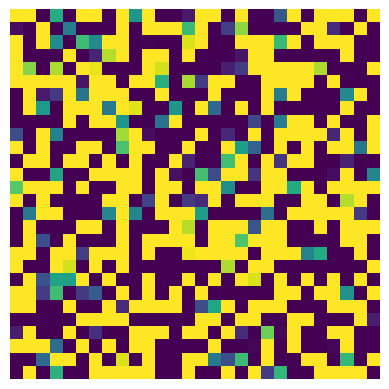

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Définir une fonction pour générer une image aléatoire de Pokémon
def generate_random_pokemon_image(generator, latent_dim):
    # Générer un bruit aléatoire
    noise = np.random.normal(0, 1, (1, latent_dim))
    # Utiliser le générateur pour produire une image
    generated_image = generator.predict(noise)
    # Mettre à l'échelle les valeurs des pixels entre 0 et 1
    generated_image = (generated_image + 1) / 2.0
    # Afficher l'image générée
    plt.imshow(generated_image[0])
    plt.axis('off')
    plt.show()

# Utiliser la fonction pour générer une image aléatoire de Pokémon
generate_random_pokemon_image(generator, latent_dim)